# Devoir 1

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Question:
- est ce que graphique borne min alors ecart-type seulement +

## Les bandits stochastiques

### [10 points] Les environnements de bandits stochastiques

#### Récompenses de distributions de Bernoulli

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions de Bernoulli. Votre classe doit recevoir en entrée les probabilités de succès de chaque action ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [32]:
class BernoulliBandit:
    
    def __init__(self, probabilities, seed=None):
        self.probabilities = probabilities
        self.rng = np.random.default_rng(seed)

        self.n = len(probabilities)
        self.optimal_action = np.argmax(probabilities)
        self.optimal_reward = probabilities[self.optimal_action]

        self.action_history = []
        self.reward_history = []

    def play(self, action):
        # pattern factory avec algo pour chaque bandit serait mieux
        action_reward = self.rng.binomial(1, self.probabilities[action])

        self.action_history.append(action)
        self.reward_history.append(action_reward)
        return action_reward
    
    # Ajouter pour simplifier les simulation
    def play_random(self):
        return self.play(np.random.randint(self.n))
    
    # retourne la meilleure action selon les l'expérience connues du bandit historique
    def get_optimal_known_action(self):
        m = np.zeros(self.n)
        for i in range(self.n):
            if self.action_history.count(i) > 0:
                m[i] = np.mean([r for a, r in zip(self.action_history, self.reward_history) if a == i])
        return np.argmax(m)
    
    def get_cumulative_regret(self):
        return np.cumsum(np.max(self.probabilities) - np.array([self.probabilities[a] for a in self.action_history]))
    

    def get_action_count(self, action):
        return sum(1 for a in self.action_history if a == action)

    def get_action_mean_reward(self, action):
        rewards = [r for a, r in zip(self.action_history, self.reward_history) if a == action]
        return np.mean(rewards) if rewards else 0

    def get_statistics_by_action(self):
        stats = {}
        for i in range(self.n):
            rewards = [r for a, r in zip(self.action_history, self.reward_history) if a == i]
            stats[i] = {
                'count': len(rewards),
                'mean': np.mean(rewards) if rewards else 0,
                'std': np.std(rewards) if rewards else 0
            }
        return stats

In [33]:
def run_strategy_analysis(strategy_func, bandit_class, T, N, strategy_params, bandit_params):
    all_regrets = []
    optimal_actions_count = []
    
    for _ in range(N):
        bandit = bandit_class(**bandit_params)
        regrets = strategy_func(bandit, T, **strategy_params)
        all_regrets.append(regrets)
        
        optimal_count = bandit.get_action_count(bandit.optimal_action)
        optimal_actions_count.append(optimal_count)
    
    all_regrets = np.array(all_regrets)
    
    return {
        'mean_regrets': np.mean(all_regrets, axis=0),
        'std_regrets': np.std(all_regrets, axis=0),
        'mean_optimal_count': np.mean(optimal_actions_count),
        'std_optimal_count': np.std(optimal_actions_count),
        'all_regrets': all_regrets,
        'all_counts': optimal_actions_count
    }

def plot_strategy_comparison(results_dict, title="Comparaison de stratégies"):
    plt.figure(figsize=(12, 6))
    
    for label, result in results_dict.items():
        mean = result['mean_regrets']
        std = result['std_regrets']
        plt.plot(mean, label=label, linewidth=2)
        # TODO: vérifier si la limite inférieure peut être négative et ajuster le fill_between
        plt.fill_between(range(len(mean)), mean, mean + std, alpha=0.2)
    
    plt.xlabel("Temps t")
    plt.ylabel("Regret cumulatif")
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def print_strategy_stats(results_dict):
    for label, result in results_dict.items():
        mean_regrets = result['mean_regrets']
        std_regrets = result['std_regrets']
        mean_count = result['mean_optimal_count']
        std_count = result['std_optimal_count']
        
        print(f"{label}:")
        print(f"  Regret final: {mean_regrets[-1]:.2f} +/- {std_regrets[-1]:.2f}")
        print(f"  Sélections optimales: {mean_count:.1f} +/- {std_count:.1f}\n")

Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$.

In [34]:
instance = BernoulliBandit([0.7, 0.6, 0.5])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et présentez-les sous la forme d'une figure pour chaque action. Affichez la moyenne empirique pour chaque action.

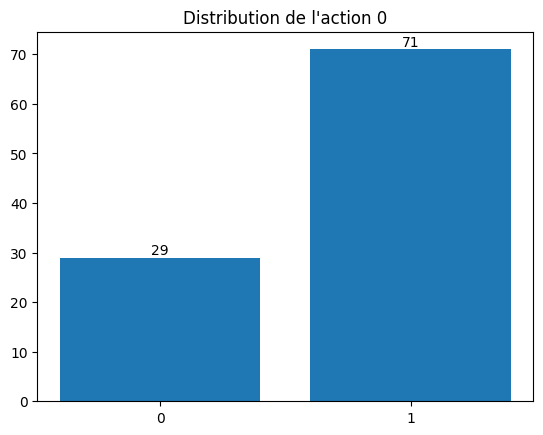

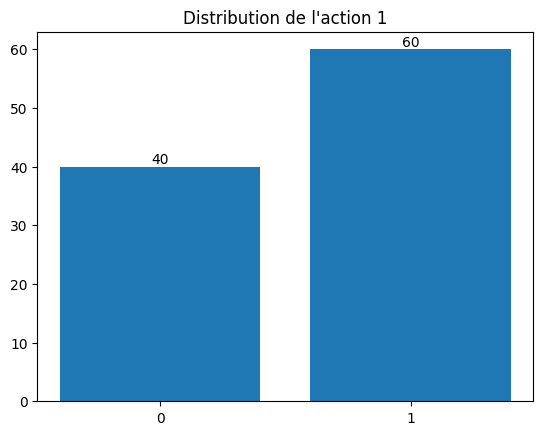

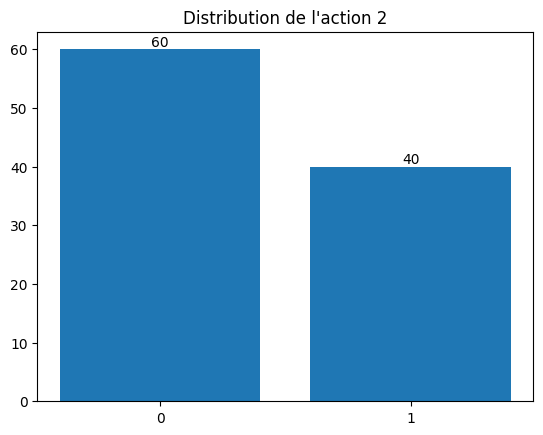

Moyenne empirique de l'action 0: 0.71
Moyenne empirique de l'action 1: 0.6
Moyenne empirique de l'action 2: 0.4


In [35]:
a0 = [instance.play(0) for _ in range(100)]
a1 = [instance.play(1) for _ in range(100)]
a2 = [instance.play(2) for _ in range(100)]

def plot_distribution(data, title):
    values, counts = np.unique(data, return_counts=True)
    bars = plt.bar(values, counts, tick_label=['0', '1'])
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height,
                 f'{height}',
                 ha='center', va='bottom')
    plt.title(f"Distribution de l'action {title}")
    plt.show()

# graphiques
plot_distribution(a0, '0')
plot_distribution(a1, '1')
plot_distribution(a2, '2')

# moyenne empirique
print("Moyenne empirique de l'action 0:", np.mean(a0))
print("Moyenne empirique de l'action 1:", np.mean(a1))
print("Moyenne empirique de l'action 2:", np.mean(a2))



#### Récompenses de distributions normales

Complétez le code suivant pour implémenter un simulateur de bandit stochastique à $k$ actions avec récompenses générées par des distributions normales. Votre classe doit recevoir en entrée l'espérance et la variance des récompenses pour chaque action, ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action demandée.

In [36]:
class NormalBandit(BernoulliBandit):

    def __init__(self, means, variances, seed=None):
        super().__init__([0] * len(means), seed)  # on n'utilise pas les probabilités du BernoulliBandit
        self.means = means
        self.variances = variances

    def play(self, action):
        action_reward = self.rng.normal(self.means[action], np.sqrt(self.variances[action]))
        self.action_history.append(action)
        self.reward_history.append(action_reward)

        return action_reward


Générez une instance de votre environnement avec la configuration $\boldsymbol \mu = (0.7, 0.6, 0.5)$ et une variance de récompenses $\sigma^2 = 1$ pour toutes les actions.

In [37]:
instance_normal = NormalBandit([0.7, 0.6, 0.5], [1, 1, 1])

Montrez que votre environnement fonctionne en jouant 100 fois chaque action sur votre instance. Collectez les récompenses et affichez la moyenne et la variance empiriques pour chaque action.

In [38]:
a0 = [instance_normal.play(0) for _ in range(100)]
a1 = [instance_normal.play(1) for _ in range(100)]
a2 = [instance_normal.play(2) for _ in range(100)]

print('la moyenne de a0 est ', round(np.mean(a0), 2), 'et la variance est ', round(np.var(a0), 2))
print('la moyenne de a1 est ', round(np.mean(a1), 2), 'et la variance est ', round(np.var(a1), 2))
print('la moyenne de a2 est ', round(np.mean(a2), 2), 'et la variance est ', round(np.var(a2), 2))

la moyenne de a0 est  0.57 et la variance est  0.72
la moyenne de a1 est  0.7 et la variance est  1.12
la moyenne de a2 est  0.44 et la variance est  1.08


### [10 points] Explore-Then-Commit (ETC)

Complétez le code suivant pour implémenter la stratégie ETC. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que la durée $m$ de la phase exploratoire accordée pour chaque action.

In [39]:
def etc(bandit: BernoulliBandit, T, m):
    n = bandit.n

    # Phase d'exploration
    for i in range(n):
        for _ in range(m):
            bandit.play(i)

    # Trouver l'action optimale
    optimal = bandit.get_optimal_known_action()

    # Phase d'exploitation
    for _ in range(T - n * m):
        bandit.play(optimal)

    return bandit.get_cumulative_regret()

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie ETC sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 2000$. Comparez ETC pour $m=50$ tirages exploratoires par action avec ETC pour $m$ optimal selon la théorie : $$m_\text{optimal} = \left\lceil \frac{4 \sigma^2}{\Delta_-^2} \ln \left( \frac{T \Delta_-^2}{4 \sigma^2} \right) \right\rceil \quad \text{avec } \Delta_- = \min_{a\neq a_\star} \Delta_a$$

Supposez que le gap de sous-optimalité minimal $\Delta_-$ est connu.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le pourcentage des réalisations pour lesquelles chaque variante a pu exploiter l'action optimale.

ETC m=50:
  Regret final: 35.35 +/- 57.88
  Sélections optimales: 1696.5 +/- 578.8

ETC m=300:
  Regret final: 90.00 +/- 0.00
  Sélections optimales: 1400.0 +/- 0.0



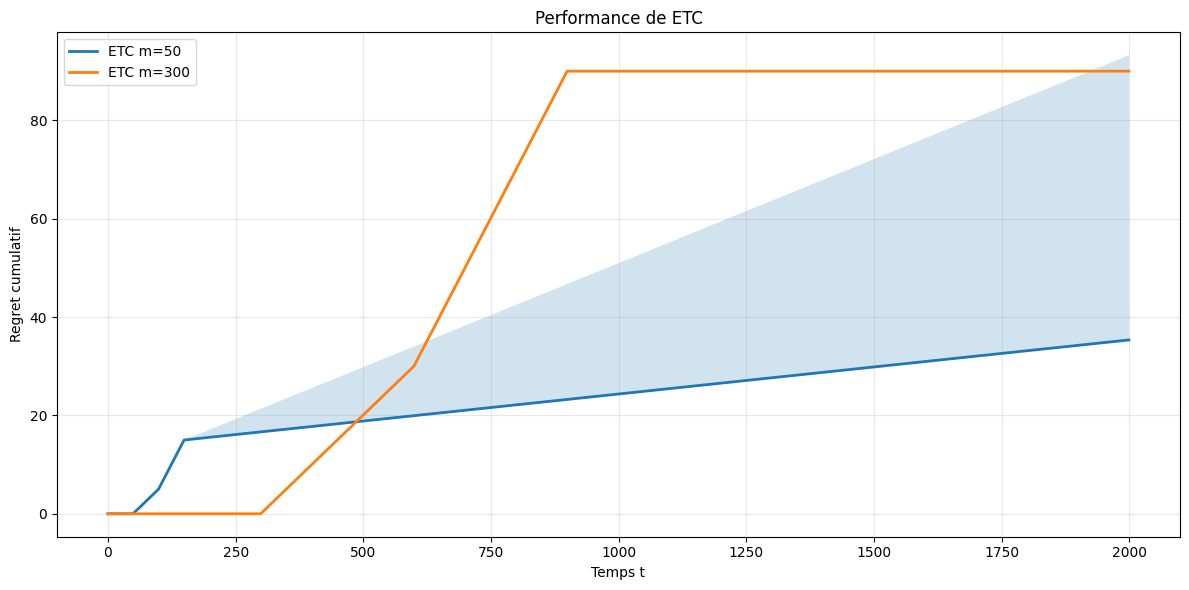

ETC m=50 a exploité l'action optimale dans 84.82% des réalisations.
ETC m=300 a exploité l'action optimale dans 70.00% des réalisations.


In [40]:
T = 2000
N = 100

results_m50 = run_strategy_analysis(etc, BernoulliBandit, 2000, 100, strategy_params={'m':50}, bandit_params={'probabilities':[0.7, 0.6, 0.5]})
results_m100 = run_strategy_analysis(etc, BernoulliBandit, 2000, 100, strategy_params={'m':300}, bandit_params={'probabilities':[0.7, 0.6, 0.5]})
print_strategy_stats({'ETC m=50': results_m50, 'ETC m=300': results_m100})
plot_strategy_comparison({'ETC m=50': results_m50, 'ETC m=300': results_m100}, title="Performance de ETC")

# Affichez le pourcentage des réalisations pour lesquelles chaque variante a pu exploiter l'action optimale.
pourcentage_optimal_m50 = (results_m50['mean_optimal_count'] / T) * 100
pourcentage_optimal_m300 = (results_m100['mean_optimal_count'] / T) * 100
print(f"ETC m=50 a exploité l'action optimale dans {pourcentage_optimal_m50:.2f}% des réalisations.")
print(f"ETC m=300 a exploité l'action optimale dans {pourcentage_optimal_m300:.2f}% des réalisations.") 




delta_- = 0.1, m_optimal = 300

m = 50

m = 300

m = 50:
  Regret final moyen: 50640.77 +/- 62465.06
  Exploitation optimale: 0.0%

m = 300:
  Regret final moyen: 122756.10 +/- 8477.70
  Exploitation optimale: 0.0%


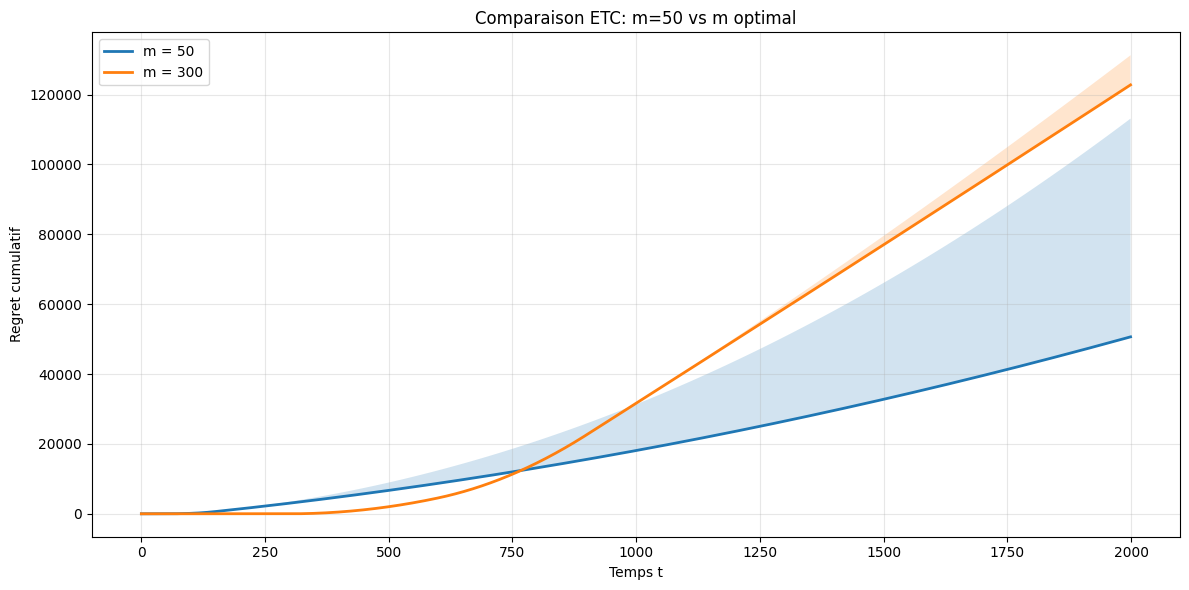

In [41]:
# Configuration de l'instance
probabilities = [0.7, 0.6, 0.5]
optimal_action = 0
optimal_reward = 0.7
T = 2000
N = 100

# Calcul de m_optimal
min_gap = 0.1
max_variance = 0.25

m_optimal = int(np.ceil((4 * max_variance / (min_gap**2)) * np.log(T * min_gap**2 / (4 * max_variance))))

print(f"delta_- = {min_gap}, m_optimal = {m_optimal}")

# Simulations avec m=50 et m_optimal
results = {}

for m in [50, m_optimal]:
    print(f"\nm = {m}")
    all_regrets = []
    optimal_exploited_count = 0

    # N réalisations
    for realization in range(N):
        bandit = BernoulliBandit(probabilities)
        regrets = etc(bandit, T, m)
        all_regrets.append(np.cumsum(regrets))

        exploitation_regrets = regrets[3*m:]
        if len(exploitation_regrets) > 0 and np.mean(exploitation_regrets) < 0.05:
            optimal_exploited_count += 1

    # Conversion en regrets cumulatifs et calcul des stats
    regrets_cumsum = np.array(all_regrets)
    mean_regrets = np.mean(regrets_cumsum, axis=0)
    std_regrets = np.std(regrets_cumsum, axis=0)

    results[m] = {
        'mean_regrets': mean_regrets,
        'std_regrets': std_regrets,
        'optimal_percentage': 100 * optimal_exploited_count / N
    }

# Affichage
plt.figure(figsize=(12, 6))

for m in [50, m_optimal]:
    plt.plot(results[m]['mean_regrets'], label=f"m = {m}", linewidth=2)
    plt.fill_between(range(len(results[m]['mean_regrets'])),
                     results[m]['mean_regrets'],
                     results[m]['mean_regrets'] + results[m]['std_regrets'],
                     alpha=0.2)

plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Comparaison ETC: m=50 vs m optimal")
plt.legend()
plt.grid(alpha=0.3)

for m in [50, m_optimal]:
    print(f"\nm = {m}:")
    print(f"  Regret final moyen: {results[m]['mean_regrets'][-1]:.2f} +/- {results[m]['std_regrets'][-1]:.2f}")
    print(f"  Exploitation optimale: {results[m]['optimal_percentage']:.1f}%")

plt.tight_layout()
plt.show()

Expliquez les régimes observés sur les courbes ainsi que les différences entre les courbes. Supportez votre discussion à l'aide des taux de convergence à l'action optimale obtenus avec chaque valeur de $m$.

__[IFT-7201]__ Montrez comment obtenir l'équation de $m$ optimal sur un environnement à $k = 3$ actions.

### [10 points] $\varepsilon$-greedy

Complétez le code suivant pour implémenter la stratégie $\varepsilon$-greedy avec taux d'exploration $\varepsilon$ fixe. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'exploration $\varepsilon$.

In [ ]:
def egreedy(bandit, T, epsilon):
    #déplacer logique de calcul du regret dans la classe BernoulliBandit pour éviter de devoir le faire à chaque fois

    # initialisation
    for i in range(bandit.n):
        bandit.play(i)

    # phase d'exploitation et d'exploration
    for t in range(bandit.n, T):
        if np.random.rand() < epsilon:
            action = np.random.randint(bandit.n)  
        else:
            action = bandit.get_optimal_known_action()  

        bandit.play(action)

    return bandit.get_cumulative_regret()

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie $\varepsilon$-greedy sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$. Comparez $\varepsilon$-greedy pour $\varepsilon \in \{0, 1/8, 1/4, 1/2, 1\}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie. Affichez le nombre de fois en moyenne (avec un écart-type) où l'action optimale est sélectionnée sur l'instance considérée avec chaque configuration de la stratégie.

In [45]:
N = 100
T = 1000

epsilons = [0, 1/8, 1/4, 1/2, 1]

results = {}

for eps in epsilons:
    all_regrets = []
    optimal_actions_count = []

    for _ in range(N):
        bandit = BernoulliBandit([0.7, 0.6, 0.5])
        regrets = egreedy(bandit, T, eps)
        all_regrets.append(regrets)

        optimal_count = sum(1 for action in bandit.action_history if action == bandit.optimal_action)
        optimal_actions_count.append(optimal_count)

    all_regrets = np.array(all_regrets)
    mean_regrets = np.mean(all_regrets, axis=0)
    std_regrets = np.std(all_regrets, axis=0)

    mean_optimal_count = np.mean(optimal_actions_count)
    std_optimal_count = np.std(optimal_actions_count)

    results[eps] = {
        'mean_regrets': mean_regrets,
        'std_regrets': std_regrets,
        'mean_optimal_count': mean_optimal_count,
        'std_optimal_count': std_optimal_count
    }

    print(f"epsilon = {eps}:")
    print(f"  Regret final moyen: {mean_regrets[-1]:.2f} +/- {std_regrets[-1]:.2f}")
    print(f"  Nombre moyen de sélections de l'action optimale: {mean_optimal_count:.1f} +/- {std_optimal_count:.1f}\n")

# graphique
plt.figure(figsize=(12, 6))

for eps in epsilons:
    mean = results[eps]['mean_regrets']
    std = results[eps]['std_regrets']
    plt.plot(mean, label=f"e = {eps}", linewidth=2)
    plt.fill_between(range(len(mean)), mean - std, mean + std, alpha=0.2)

plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Stratégie e-greedy: Comparaison pour différentes valeurs de e")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

epsilon = 0:
  Regret final moyen: 46.14 +/- 66.63
  Nombre moyen de sélections de l'action optimale: 644.3 +/- 471.6

epsilon = 0.125:
  Regret final moyen: 30.56 +/- 26.51
  Nombre moyen de sélections de l'action optimale: 752.5 +/- 256.2

epsilon = 0.25:
  Regret final moyen: 33.38 +/- 15.99
  Nombre moyen de sélections de l'action optimale: 766.0 +/- 138.6



KeyboardInterrupt: 

Expliquez les différences observées entre les courbes. Expliquez les nombres de tirages de l'action optimale en référant aux bornes inférieures sur le pseudo-regret cumulatif de la stratégie $\varepsilon$-greedy pour les configurations $\varepsilon = 0$ et $\varepsilon = 1$.

epsilon 0 correspond à seulement de l'Exploration et

### [10 points] UCB

Complétez le code suivant pour implémenter la stratégie UCB1 (Auer et al., 2002). Votre fonction doit recevoir en entrée l'instance de bandit à aborder ainsi que la durée de l'horizon de temps $T$.

In [ ]:
def ucb1(bandit, T):
    for t in range(bandit.n):
        bandit.play(t)  # initialisation
    
    for t in range(bandit.n, T):
        prediction = [bandit.get_action_mean_reward(i) + np.sqrt(2 *np.log(t+1) / bandit.get_action_count(i)) for i in range(bandit.n)]
        action = np.argmax(prediction)
        bandit.play(action)

    return bandit.get_regret_cumulatif()

Considérez l'instance de bandits $\boldsymbol \mu = (0.7, 0.6, 0.5)$ avec récompenses générées par des distributions de Bernoulli. Appliquez la stratégie UCB1 sur $N=100$ réalisations de cette instance sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

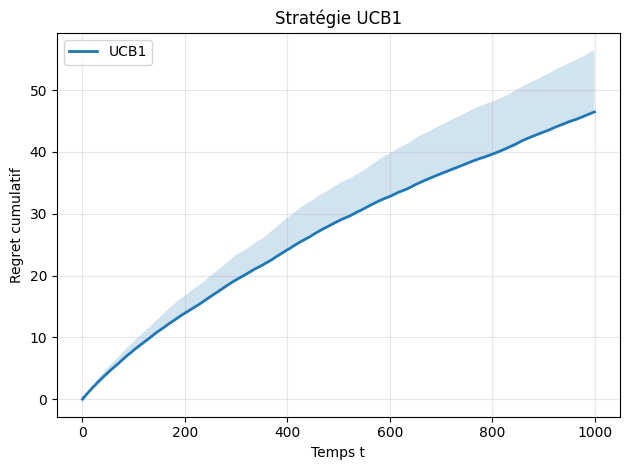

In [ ]:
def ucb1(bandit, T):
    actions_history = []

    actions_mean_rewards = np.zeros(bandit.n)
    actions_count = np.zeros(bandit.n)
    
    for t in range(T):
        action = 0
        if t < bandit.n:
            action = t
            actions_history.append(action)
        else:
            prediction = [actions_mean_rewards[i] + np.sqrt(np.log(t**4) / (2 * actions_count[i])) for i in range(bandit.n)]
            action = np.argmax(prediction)
            actions_history.append(action)

        reward = bandit.play(action)
        actions_mean_rewards[action] += (reward - actions_mean_rewards[action]) / (actions_count[action] + 1)
        actions_count[action] += 1

    return np.cumsum([max(bandit.probabilities) - bandit.probabilities[a] for a in actions_history])
#####
N = 100
T = 1000

all_regrets = [ucb1(BernoulliBandit([0.7, 0.6, 0.5]), T) for _ in range(N)]

mean = np.mean(all_regrets, axis=0)
std = np.std(all_regrets, axis=0)
plt.plot(mean, label=f"UCB1", linewidth=2)
plt.fill_between(range(len(mean)), mean, mean + std, alpha=0.2)

plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Stratégie UCB1")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Expliquez la forme de la courbe obtenue.

### [10 points] Thompson Sampling (TS)

Complétez le code suivant pour implémenter la stratégie TS destinée à des bandits stochastiques dont les récompenses suivent des distributions normales de variance connue $\sigma^2$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, la valeur des paramètres a priori ($\mu_0$ et $\sigma_0$), ainsi que la variance des observations ($\sigma^2$).

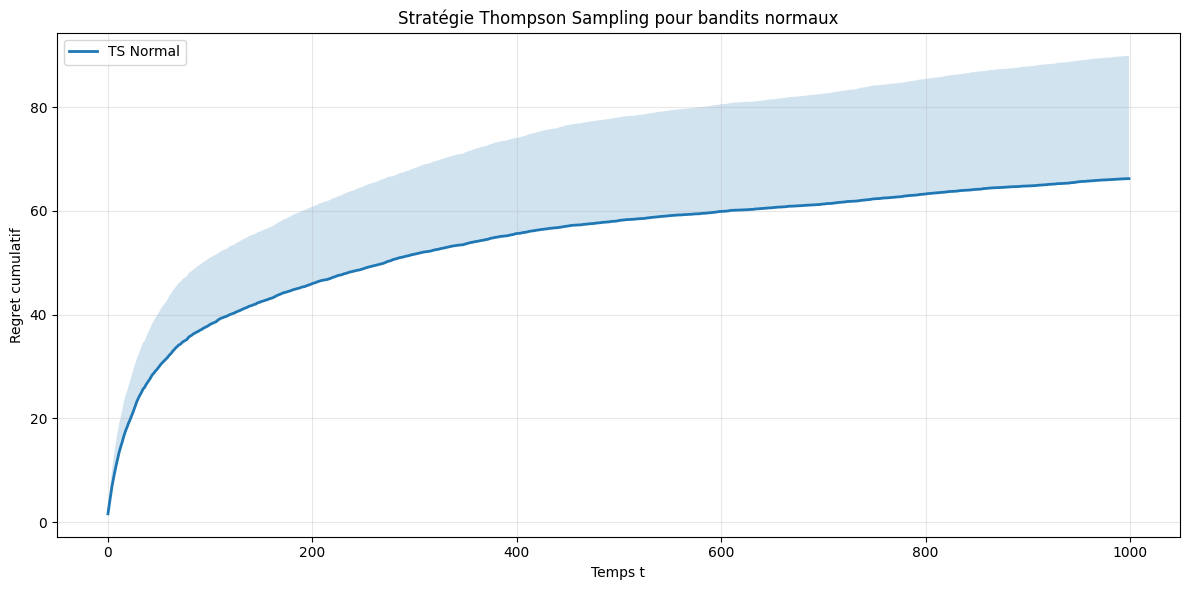

In [ ]:
def ts_normal(bandit, T, mu_0, sigma_0, sigma):
    actions_history = []
    n = bandit.n
    
    mu_posts = np.array([mu_0] * n, dtype=float)
    sigma_posts = np.array([sigma_0] * n, dtype=float)
    
    for t in range(T):
        theta_samples = np.random.normal(mu_posts, sigma_posts)
        action = np.argmax(theta_samples)
        

        reward = bandit.play(action)
        actions_history.append(action)
        
        precision_prior = 1 / (sigma_posts[action] ** 2)
        precision_obs = 1 / (sigma ** 2)
        precision_post = precision_prior + precision_obs
        
        mu_posts[action] = (precision_prior * mu_posts[action] + precision_obs * reward) / precision_post
        sigma_posts[action] = np.sqrt(1 / precision_post)
    return np.cumsum([max(bandit.means) - bandit.means[a] for a in actions_history])


N = 100
T = 1000
sigma = 1
mu_0 = 2
sigma_0 = 1

regrets_all = [ts_normal(NormalBandit(np.random.normal(2, 1, 10), [sigma**2]*10, seed=1), T, mu_0, sigma_0, sigma) for _ in range(N)]
mean_regrets = np.mean(regrets_all, axis=0)
std_regrets = np.std(regrets_all, axis=0)


plt.figure(figsize=(12, 6))
plt.plot(mean_regrets, label="TS Normal", linewidth=2)
plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
plt.xlabel("Temps t")
plt.ylabel("Regret cumulatif")
plt.title("Stratégie Thompson Sampling pour bandits normaux")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(2, 1)$. Appliquez la stratégie TS à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 1000$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Justifiez le choix des paramètres a priori utilisés dans votre expérience.

### [10 points] Apprentissage par le gradient de la politique

Complétez le code suivant pour implémenter la stratégie d'apprentissage par gradient de la politique avec _baseline_ $B_t$ correspondant à la moyenne des récompenses observées jusqu'au temps $t-1$. Votre fonction doit recevoir en entrée l'instance de bandit à aborder, la durée de l'horizon de temps $T$, ainsi que le taux d'apprentissage $\alpha > 0$.

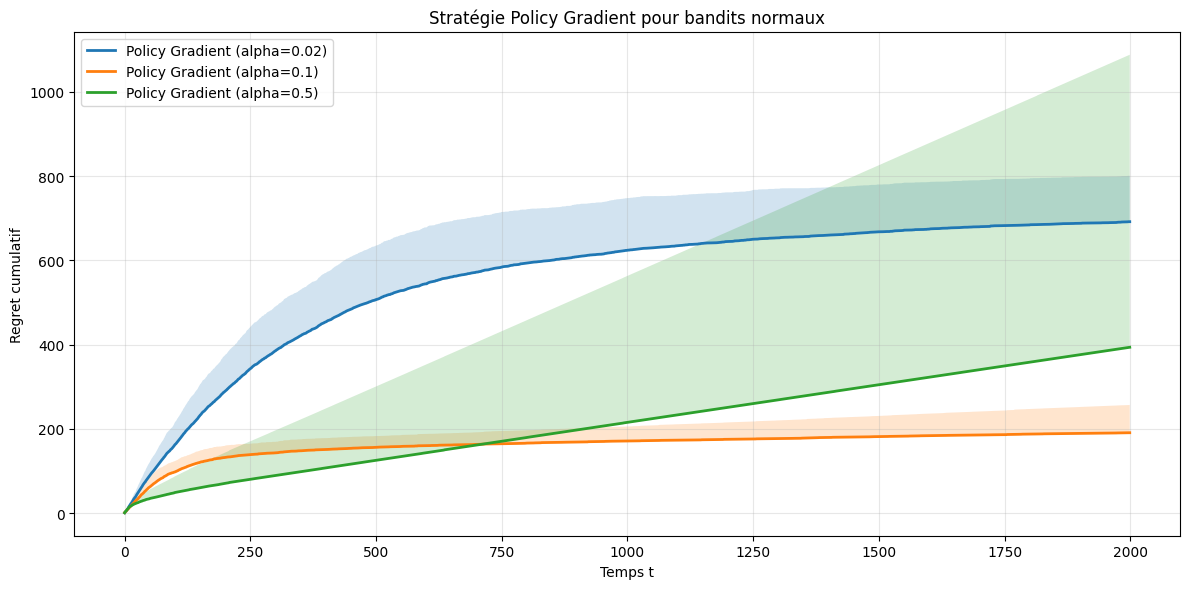

In [ ]:
def policy_gradient(bandit, T, alpha):
    actions_history = []
    total_rewards = 0
    n = bandit.n
    preferences = np.zeros(n)

    for t in range(T):
        pi = np.exp(preferences) / np.sum(np.exp(preferences))
        base_line_value = total_rewards / t if t > 0 else 0

 
        action = np.random.choice(n, p=pi)

        actions_history.append(action)
        reward = bandit.play(action)
        total_rewards += reward

        for i in range(len(preferences)):
            if i == action:
                preferences[i] += alpha * (reward - base_line_value) * (1 - pi[actions_history[-1]])
            else:
                preferences[i] -= alpha * (reward - base_line_value) * (pi[i])


    return np.cumsum([max(bandit.means) - bandit.means[a] for a in actions_history])


N = 10
T = 2000
sigma = 1

alphas = [1/50, 1/10, 1/2]

plt.figure(figsize=(12, 6))
for alpha in alphas:
    regrets_all = [policy_gradient(NormalBandit(np.random.normal(0, 1, 10), [sigma**2]*10, seed=1), T, alpha) for _ in range(N)]
    mean_regrets = np.mean(regrets_all, axis=0)
    std_regrets = np.std(regrets_all, axis=0)


    plt.plot(mean_regrets, label=f"Policy Gradient (alpha={alpha})", linewidth=2)
    plt.fill_between(range(len(mean_regrets)), mean_regrets, mean_regrets + std_regrets, alpha=0.2)
    plt.xlabel("Temps t")
    plt.ylabel("Regret cumulatif")
    plt.title("Stratégie Policy Gradient pour bandits normaux")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
plt.show()

Considérez la classe d'environnements à 10 actions dont les récompenses suivent des distributions normales de variance $\sigma^2 = 1$ et dont les configurations sont telles que $\mu_a \sim \mathcal N(0, 1)$. Appliquez la stratégie d'apprentissage par gradient de politique à 100 instances de cette classe (une réalisation par instance) sur un horizon temporel $T = 2000$ avec différentes valeurs de taux d'apprentissage $\alpha \in \{ 1/50, 1/10, 1/2 \}$.

Présentez une figure montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus, pour chaque configuration de la stratégie.

Discutez de l'impact du taux d'apprentissage en vous appuyant sur les résultats obtenus. Expliquez notamment la forme des courbes en référant au compromis entre l'exploration et l'exploitation.

## Les bandits stochastiques contextuels

### [10 points] Les environnements de bandits stochastiques linéaires

Vous travaillez dans une entreprise comprenant différents systèmes qui mériteraient d'être optimisés. Vous aimeriez investiguer le potentiel des stratégies de bandits stochastiques linéaires pour aborder la tâche d'ajustement des paramètres d'un système de manière à maximiser sa performance.

Complétez le code suivant pour implémenter un simulateur générique permettant de réaliser des expériences sur des problèmes de bandits stochastiques linéaires adaptés à cette application. Considérez que chaque récompense $R_t$ est générée en appliquant un bruit $\eta_t \sim \mathcal N(0, \sigma^2)$ à la fonction de performance évaluée à l'action $A_t$. Votre classe doit recevoir en entrée la fonction de caractéristiques à utiliser, le paramètre $\omega_\star$ gouvernant la fonction de récompense, la variance du bruit $\sigma^2$, la liste des actions discrètres considérées ($x_1, x_2, \dots, x_k$), ainsi qu'un germe aléatoire permettant de fixer la réalisation de l'instance. La fonction _play_ doit échantillonner et retourner une récompense pour l'action d'indice donné.

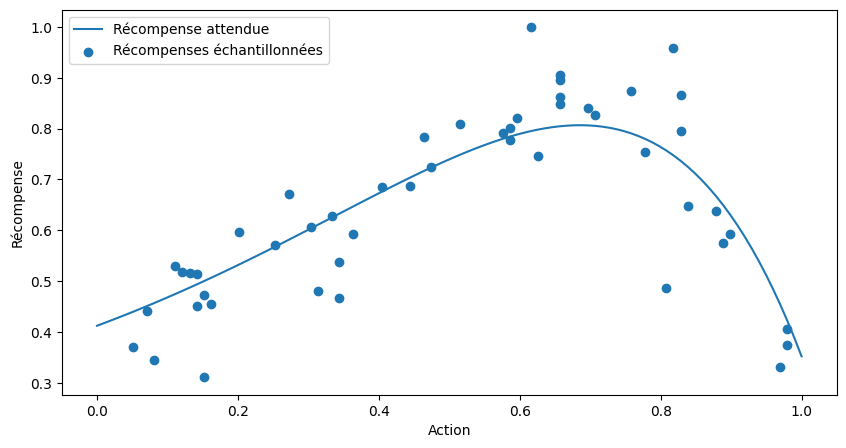

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class LinGaussianBandit:
    def __init__(self, phi, omega, noise_variance, action_space, seed=None):
        self.phi = phi
        self.omega = omega
        self.noise_variance = noise_variance
        self.action_space = action_space
        self.rng = np.random.default_rng(seed)
        self.noise = lambda: self.rng.normal(0, np.sqrt(self.noise_variance))
    
    def play(self, action):
        features = self.phi(self.action_space[action])
        reward = np.dot(features, self.omega) + self.noise()
        return reward
    
omega = np.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])
phi = lambda x: np.array([1, x, x**2, x**3, x**4, x**5, x**6, x**7])

lineGaussianBandit = LinGaussianBandit(phi, omega, noise_variance=0.01, action_space=np.linspace(0, 1, 100), seed=1)


actions = np.random.choice(len(lineGaussianBandit.action_space), 50)
rewards = [lineGaussianBandit.play(a) for a in actions]
expected_rewards = [np.dot(phi(lineGaussianBandit.action_space[a]), omega) for a in actions]

plt.figure(figsize=(10, 5))
plt.plot(lineGaussianBandit.action_space, [np.dot(phi(x), omega) for x in lineGaussianBandit.action_space], label='Récompense attendue')
plt.scatter(lineGaussianBandit.action_space[actions], rewards, label='Récompenses échantillonnées')
plt.xlabel('Action')
plt.ylabel('Récompense')
plt.legend()
plt.show()

Considérez une instance spécifique de cet environnement caractérisée par une variance du bruit $\sigma^2 = 0.01$, un espace d'action $\mathcal X$ fini et discret correspondant à 100 valeurs régulièrement espacées sur l'intervalle $[0, 1]$, la fonction de caractéristique $\varphi(x) = (1, x, x^2, x^3, x^4, x^5, x^6, x^7)$, ainsi que le paramètre $\omega_\star$ suivant : 

In [ ]:
omega = numpy.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])

Pour montrer que votre environnement fonctionne, présentez une réalisation de cette instance pour 50 actions sélectionnées aléatoirement sur $\mathcal X$. Votre figure devrait contenir la fonction de récompense attendue en plus des récompenses échantillonnées.

À quoi pourrait correspondre le bruit dans cette application?

### [15 points] OFUL

Complétez le code suivant pour implémenter la stratégie OFUL adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, la variance du bruit $\sigma^2$, ainsi que la norme $\lVert \omega_\star \rVert_2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions et utilisez un niveau de confiance $\delta = 1/t$.

In [ ]:
def oful(bandit, T, regularization, noise_variance, norm_function):
    d = len(bandit.phi(0))
    omega_hat = np.zeros(d) 
    V_0_inv = 1 / regularization * np.eye(d)

    actions_history = []
    phi_history = []
    reward_history = []

    for t in range(T):
        actions = 0
        if t < 1:
            actions = np.random.choice(len(bandit.action_space))
        else:
            actions = np.argmax([np.dot(bandit.phi(a), omega_hat) + np.sqrt(noise_variance * norm_function(np.dot(V_0_inv, bandit.phi(a)))) for a in range(len(bandit.action_space))])

        reward = bandit.play(actions)

        actions_history.append(actions)
        phi_history.append(bandit.phi(actions))
        reward_history.append(reward)

        omega_hat, residuals, rank, s = np.linalg.lstsq(phi_history, reward_history, rcond=None)

    return np.cumsum([max(bandit.means) - bandit.means[a] for a in actions_history])



N = 10
T = 1000
omega = np.array([0.41218989, 0.51717332, 0.40751546, 0.03405839, -0.29501341, -0.53931605, -0.07674824, -0.10778418])
phi = lambda x: np.array([1, x, x**2, x**3, x**4, x**5, x**6, x**7])

lambda_values = [0.001, 0.01, 0.1, 1.0]

all_regrets = [oful(LinGaussianBandit(phi, omega, noise_variance=0.01, action_space=np.linspace(0, 1, 100), seed=1), T, regularization=1.0, noise_variance=0.01, norm_function=np.linalg.norm) for _ in range(N)]


mean_regret = np.mean(all_regrets, axis=0)
std_regret = np.std(all_regrets, axis=0)
plt.figure(figsize=(10, 5))
plt.plot(mean_regret, label='OFUL', linewidth=2)
plt.fill_between(range(len(mean_regret)), mean_regret - std_regret, mean_regret + std_regret, alpha=0.2)
plt.xlabel('Temps t')
plt.ylabel('Regret cumulatif')
plt.title('Performance de OFUL')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

AttributeError: 'LinGaussianBandit' object has no attribute 'means'

Comment se traduit le niveau de confiance $\delta$ considéré sur les intervalles de confiance considérés?

Le niveau de confiance devient plus séréré

Appliquez la stratégie OFUL sur $N=100$ réalisations de l'instance de bandits stochastiques linéaires décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit $\sigma^2$ et la norme $\lVert \omega_\star \rVert_2$ sont des informations connues. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Expliquez les résultats obtenus.

__[IFT-7201]__ En pratique, il peut arriver que la variance du bruit soit inconnue, donc qu'une estimation soit utilisée. Expliquez quel sera l'impact sur l'exploration et l'exploitation si la variance du bruit est sous/sur-estimée.

### [15 points] TS pour bandits stochastiques linéaires

Complétez le code suivant pour implémenter une stratégie TS linéaire adaptée au type d'environnement décrit précédemment. Votre fonction doit recevoir en entrée l'instance de bandits stochastiques linéaires à aborder, la durée de l'horizon de temps $T$, le paramètre de régularisation $\lambda$, ainsi que la variance du bruit $\sigma^2$. Considérez que la première action effectuée ($A_1$) est choisie aléatoirement uniformément sur l'espace des actions.

In [12]:
def lints(bandit, T, regularization, noise_variance):
    # compléter
    pass

Appliquez la stratégie LinTS sur $N=100$ réalisations de l'instance de bandits décrite précédemment, sur un horizon temporel $T = 1000$ en supposant que la variance du bruit est connue. Investiguez l'impact de la régularisation en considérant $\lambda \in \{ 0.001, 0.01, 0.1, 1 \}$.

Présentez vos résultats sous la forme de figures montrant le pseudo-regret cumulatif moyenné sur les réalisations, avec un écart-type au-dessus.

Discutez des résultats obtenus en comparaison avec les résultats obtenus en utilisant la stratégie OFUL.